# Poisson Test

There are many tools that exists for hypothesis testing of whether a poisson distribution has $\hat{\lambda} = \lambda_{\circ} $ or not. But what I want to test is that a particular data comes from a poisson distribution or not. For this there are different approaches. Ranging from visual to statistical analysis.

Through online research I will try to find some basic methods to do the same. But I would need a second eye to validate the methods.

Based on the [StackExchange](https://stats.stackexchange.com/questions/1174/how-can-i-test-if-given-samples-are-taken-from-a-poisson-distribution), I came to know about the 3 methods.
- Likelihood Ratio Test
- Poisson Dispersion Test
- Use of Neyman-Scot Statistic

Emanuele also suggested a method to test, I would try to elaborate that as well. 

### Note for code
I could not find easily an R/Python code which does the same. Any suggestion on the same will be helpful.

## Likelihood Ratio Test


### Theory
How I understand it, the likelihood ratio ($\Lambda$) is given as the ratio of likelihood under null hypothesis $H_{\circ}$ and the likelihood ratio under the union of $H_{\circ}$ and the alternate hypothesis $H_{a}$. 

And we know (somehow) that -2log($\Lambda$) is $\chi^2_k$ distributed, with k degrees of freedom.

Ideally the entire dataset is divided in $n$ bins. And the null hypothesis is that entire dataset comes from one poisson distribution with a parameter $\hat{\lambda}$, while the under the union of $H_\circ$ and $H_a$ it is considered that each of the bins have their individual $\hat{\lambda_i}$. In an ideal case they will be all equal to $\hat{\lambda}$ and then $\Lambda$ will be equal to 1. Intuition is that as far we are from 1 (less than 1), more unlikely we are that the data comes from a poisson distribution.  




### Application

Under these assumption it is easy to find that -2log$\Lambda$ = $2\sum_{i=1}^{n}x_ilog\frac{x_i}{\bar{x}}$

In our case, say we have 40 years of data, so n = 40. So we have 1 parameter $\lambda$ and 40 parameters as $\lambda_i$, <span style="background-color:powderblue;"> in my understanding then k - degrees of freedom should be 39 </span>. I need to check this.


### Working with ERA5 bias corrected data

We start with the temperature, and then do a linear detrend. Further we do the test for the data as described above


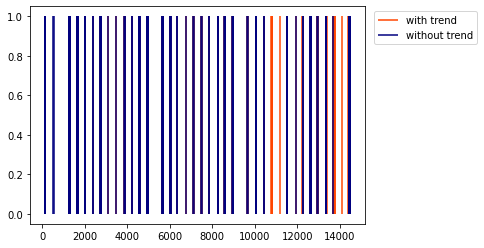

In [245]:
from netCDF4 import Dataset
from datetime import datetime, timedelta
from scipy import signal
import matplotlib.pylab as plt

var = 'Rainf'
fpath_data = '/Users/anand/Documents/data/bias-corrected-reanalysis/'+var+'_WFDE5_CRU_dly_v1.0.nc'

data = Dataset(fpath_data, 'r')

def lat_lon_to_index(lat, lon):
    lat_ind = (lat+90+0.5)/0.5
    lon_ind = (lon+180+0.5)/0.5 
    
    return int(lat_ind), int(lon_ind)

# Read the data for a particular location

# # Leipzig

# lat = 51.33
# lon = 12.37


# Zurich

lat = 47.37
lon = 8.54


# # New Delhi

# lat = 28.61
# lon = 77.20

# # Cannberra
# lat = -35.28
# lon = 149.130

lat_ind, lon_ind = lat_lon_to_index(lat, lon)

Tair = data[var][:,lat_ind,lon_ind]

# First detrend the temperature

Tair_trend = signal.detrend(Tair, type = 'constant')
Tair_no_trend = signal.detrend(Tair, type = 'linear')

fig, ax = plt.subplots(1,1)

ax.vlines(trend_ind, ymin = 0, ymax = 1, color = 'orangered', label = 'with trend' )
ax.vlines(no_trend_ind, ymin = 0, ymax = 1, color = 'navy', label = 'without trend')

plt.legend(bbox_to_anchor=(1.35, 1))


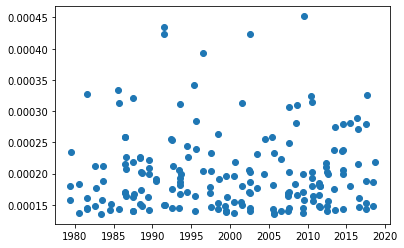

In [246]:
# Find the hottest 3 months

strt_dt = datetime(1900,1,1)

day_list= [strt_dt+timedelta(hours=hr) for hr in data['time'][:]]

avg_temp = np.zeros(12)

for i in range(1,13):
    
    ind = [d.month==i for d in day_list] 
    
    avg_temp[i-1] = np.average(Tair_no_trend[ind])

# Sort in descending order
hottest_months = [1+ month_ind for month_ind in  np.argsort(-avg_temp)[:3]]

# make a 2 D array with date and temperature

dt_3 = []
Tair_3 = []

for time, temp in zip(day_list, Tair_no_trend):    
    if time.month in hottest_months:
        dt_3.append(time)
        Tair_3.append(temp)


# Compute 95 percent 
perc_95 = np.percentile(Tair_3, 95)

dt_3_95 = []
Tair_3_95 = []

for time, temp in zip(dt_3, Tair_3):    
    if temp>perc_95:
        dt_3_95.append(time)
        Tair_3_95.append(temp)

            
fig, ax = plt.subplots(1,1)
ax.scatter(dt_3_95, Tair_3_95)


4.6


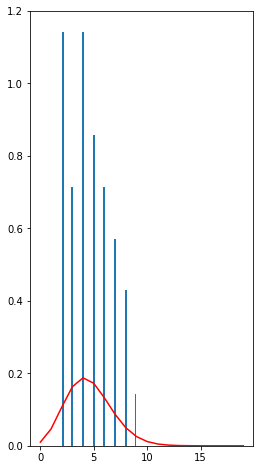

In [247]:
from scipy.stats import poisson

# Calculate the number of events in each year

n_events_year = np.zeros(2019-1979)

for time in dt_3_95:
    i = time.year-1979 
    n_events_year[i]+=1 

mu = np.average(n_events_year)
print(mu)
k_list= np.arange(20)

prob = poisson.pmf(k_list, mu)

# plot the histogram and the poisson distribution    

fig, ax = plt.subplots(1,1, figsize = (4,8))
ax.hist(n_events_year, bins = 40, density = True)
ax.plot(k_list, prob, color = 'r')

    

### Likelihood Ratio test 

[3. 2. 4. 3. 4. 2. 3. 8. 6. 7. 5. 2. 4. 5. 8. 3. 5. 2. 5. 4. 6. 4. 4. 8.
 2. 2. 6. 2. 9. 4. 6. 7. 7. 7. 4. 6. 2. 5. 5. 3.]


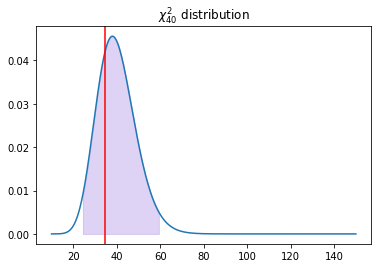

In [248]:
## Lets look at a chi square distribution with k = 39
from scipy.stats import chi2
import numpy as np
import matplotlib.pylab as plt


def lr_test(n_events_year):
    
    mu = np.average(n_events_year)
    arr_2loglambda = 2*np.multiply(n_events_year,np.log(n_events_year/mu))
    neg_2loglambda = np.nansum(arr_2loglambda)
    df = np.count_nonzero(~np.isnan(arr_2loglambda))
    print(n_events_year)
    print(arr_2loglambda)
    # Generate 500 x points between 1 to 99 percentile values
    x = np.linspace(10, 150, 500)
    y = chi2.pdf(x,df)
    conf_max = chi2.ppf(0.975,df)
    conf_min = chi2.ppf(0.025,df)
    
    x_between = np.linspace(conf_min, conf_max, 400)
    y_conf = chi2.pdf(x_between,df)
    
    fig, ax = plt.subplots(1,1)
    ax.plot(x,y)
    ax.fill_between(x_between, y_conf, color = 'mediumpurple', alpha = 0.3)
    title = '$\chi^{2}_{'+str(df)+'}$ distribution'
    plt.title(title)
    ax.axvline(x = neg_2loglambda, color = 'r')
    
lr_test(n_events_year)

[3 1 5 1 5 8 1 3 5 4 5 4 3 3 6 7 8 7 8 4 1 6 3 7 4 4 4 5 3 4 4 3 2 5 3 5 1
 8 7 4]


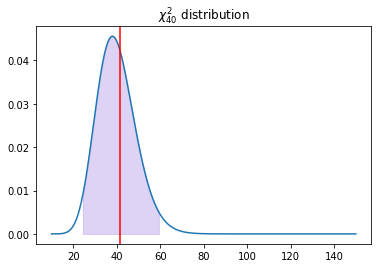

In [249]:
## Lets look at an example from true poisson distribution

n_events_sim = poisson.rvs(mu, size= 40)
lr_test(n_events_sim)